# Hello!

I often have difficulties to collect **market data** from **Bovespa** (brazil stocks).

So, in this Kernel, I'll show two API's that I'm using to get some info and some example of analysis

Feel free to comment or ask anything!
:D

The two API's are:

## quandl

## alpha_vantage

The first thing we have to do is get an access token, just need an email and a login in these links:

[https://www.alphavantage.co/](http://)

[https://www.quandl.com/](http://)

Here I'm addressing the alphavatage token as:

    My_Key = "put your key here"

And quandl as:

    quandl_Key = "put your other key here"

for quandl, we just call the lines below and it's all set:

    #AUTHENTICATION
    import quandl
    quandl.ApiConfig.api_key = My_Other_Key

In [1]:
#Importing necessary tools:

#from alpha_vantage.timeseries import TimeSeries
#rom alpha_vantage.foreignexchange import ForeignExchange    ------> (this part I'll do in my pc, and only will explain here)

import pandas as pd #We all love pandas
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #plot
import seaborn as sns #more ploting
import datetime 

from sklearn.linear_model import LinearRegression #sklearn for our regression models
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

### P.S.: Unhappy, we cannot run the code bellow here in Kaggle, but I'll continue the process, and import the already extracted DataSe further ahead. ^^


    #Time Period
    start = datetime.datetime(2016, 1, 5)
    end = (2018, 12, 27)


    #Bovespa Data Colection:
    ts = TimeSeries(key=My_Key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=Indice_BOVESPA, outputsize='full')
    bovespa = data['2016':'2018']
    bovespa['var'] = bovespa['4. close'].pct_change() * 100
    target = []
    for i in range(len(bovespa)):
        if i == len(bovespa)-1:
            break
        target.append(bovespa['var'].iloc[i + 1])
    target.append(np.nan)
    bovespa['target'] = target
    bovespa = bovespa.replace([np.inf, -np.inf], np.nan)
    bovespa = bovespa.replace(0, np.nan)
    bovespa.fillna(method='ffill', inplace=True)

    #Dolar to Reais (USD to BRL)
    forex = quandl.get('FRED/DEXBZUS', start_date=start, end_date=end)
    forex['dolar_var'] = forex['Value'].pct_change() * 100

    
    #Choose a Stock
    stock = 'ITSA4.SA'
    
    #Stock collection:
    ts = TimeSeries(key=My_Key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=stock, outputsize='full')
    df_stock = data['2016':'2019']
    df_stock['var'] = df_stock['4. close'].pct_change() * 100
    target = []
    for i in range(len(df_stock)):
        if i == len(df_stock)-1:
            break
        target.append(df_stock['var'].iloc[i + 1])
    target.append(np.nan)
    df_stock['target'] = target
    df_stock.fillna(method='ffill', inplace=True)
    df_stock = df_stock.drop(['1. open', '2. high', '3. low', '5. volume'], axis=1)


    #concatenating all data
    df = df_stock.join(bovespa)
    df = df.join(forex)
    df.fillna(method='ffill', inplace=True)

# Ok, now I'll import a Dataset that I collected doing the steps above, so we can do some other tests... 

In [2]:
df = pd.read_csv("../input/stock_itausa.csv", index_col='date')

In [3]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2017-01-02,7.4055,7.4507,7.3694,7.4146,4589559.0
2017-01-03,7.4507,7.7397,7.4507,7.7397,18882424.0
2017-01-04,7.6855,7.7939,7.6674,7.7848,9621034.0
2017-01-05,7.8029,7.9384,7.7307,7.8571,17324815.0
2017-01-06,7.8571,7.9023,7.7668,7.8300,12229672.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 2017-01-02 to 2018-12-28
Data columns (total 5 columns):
1. open      500 non-null float64
2. high      500 non-null float64
3. low       500 non-null float64
4. close     500 non-null float64
5. volume    500 non-null float64
dtypes: float64(5)
memory usage: 23.4+ KB


# We have 500 entries, each one represents a day, and the time-range is from start 2017 to end 2018

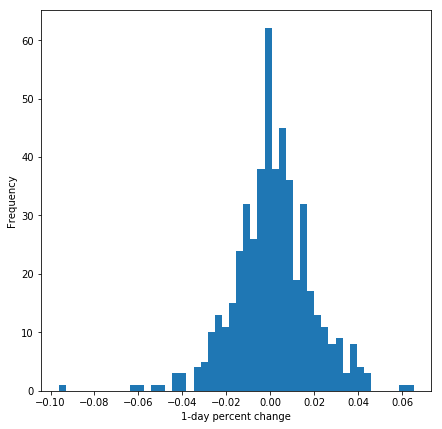

In [5]:
# Histogram of the daily price change percent of Adj_Close 
plt.figure(figsize=(7,7))
df['4. close'].pct_change().plot.hist(bins=50)
plt.xlabel('1-day percent change')
plt.show()

In [6]:
forecast_out = int(15) # predicting 15 days into future
df['Prediction'] = df[['4. close']].shift(-forecast_out) #  label column with data shifted 30 units up
target = df[['4. close']][-forecast_out:]

In [7]:
# Maybe the day of week help us:
df.index = pd.to_datetime(df.index)
days_of_week = pd.get_dummies(df.index.day_name())
days_of_week.index = df.index
df = pd.concat([df, days_of_week], axis=1)


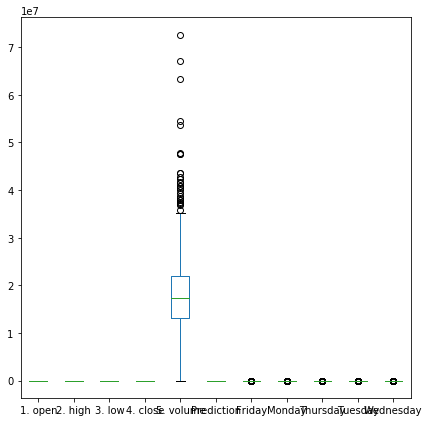

In [8]:
#Let's see our boxplot of features:
df.plot(kind='box', figsize=(7,7))

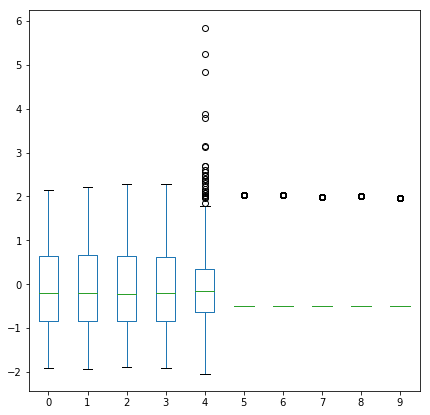

In [9]:
#This isn't looking good... We should normalize it.
X = np.array(df.drop(['Prediction'], 1))
X = preprocessing.scale(X)

X_forecast = X[-forecast_out:] 
X = X[:-forecast_out] 

test = pd.DataFrame(X)
test.plot(kind='box', figsize=(7,7))

In [10]:
y = np.array(df['Prediction'])
y = y[:-forecast_out]

In [11]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    # Training
    clf = LinearRegression()
    clf.fit(X_train,y_train)
    # Testing
    confidence = clf.score(X_test, y_test)
    print("confidence: ", confidence)

confidence:  0.7581573155202945


# In the test above, we used train_test_split of sklearn package... but this method divide our data in a random order... would be better for a time series splitting the data using the following logic:

    train_features = feature[:train_size]
    train_targets = target[:train_size]

    test_features = feature[train_size:]
    test_targets = target[train_size:]
  

## Testing a Randon Forest model: 

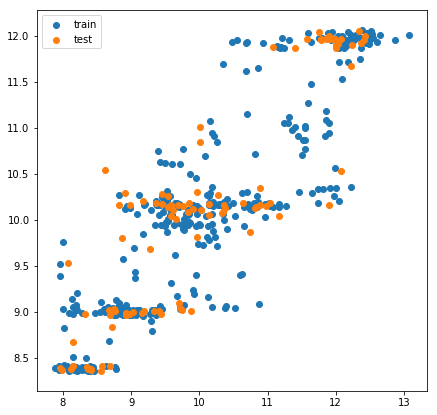

In [12]:
# random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(X_train, y_train)
train_predictions = rfr.predict(X_train)
test_predictions = rfr.predict(X_test)

# scatter plot with train and test actual vs predictions
plt.figure(figsize=(7,7))
plt.scatter(y_train, train_predictions, label='train')
plt.scatter(y_test, test_predictions, label='test')
plt.legend()
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

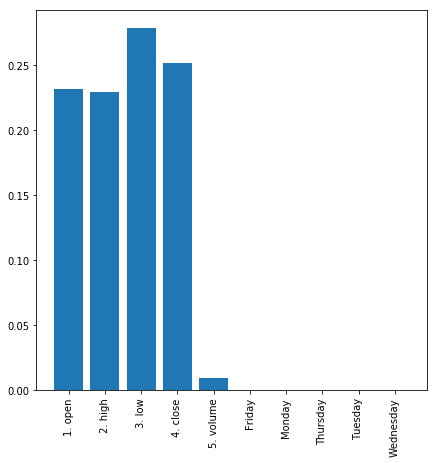

In [13]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_
labels = df.drop('Prediction', axis=1).columns.values
plt.figure(figsize=(7,7))
plt.bar(np.arange(10), importances, tick_label=labels)
plt.xticks(rotation=90)

## Since our weekday is not relevant to the model, we can remove it...

## What about using a machine learning model now?

In [14]:
model = MLPRegressor(random_state=42, solver='lbfgs', activation='logistic')
to_plot_predict = []
to_plot_real = []

for i in range(50, len(X), 1):
    X2_train = X[:i]
    X2_test = X[i].reshape(1, -1)
    y2_train = y[:i]
    y2_test = y[i].reshape(1, -1)


    model.fit(X2_train, y2_train)
    predictions = model.predict(X2_test)

    to_plot_predict.append(predictions[0])
    to_plot_real.append(y2_test[0][0])

<Figure size 432x288 with 0 Axes>

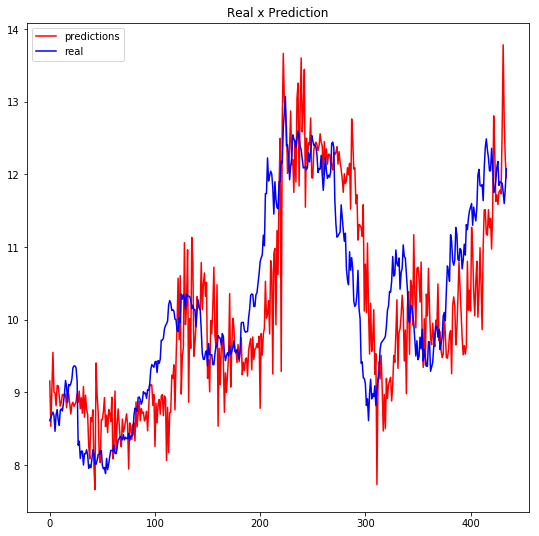

In [15]:
plt.clf()
plt.figure(figsize=(9,9))
plt.subplot()
plt.plot(to_plot_predict, c='red', label='predictions')
plt.plot(to_plot_real, c='blue', label='real')
plt.title('Real x Prediction')
plt.legend()
plt.show()

# Apparently, it's terrible... But would be good to analyse in an investors perspective. 

# did our model predict the percent change direction correct?

In [16]:
results = {'Predict':to_plot_predict,'Real':to_plot_real}
results = pd.DataFrame(results)
results['Predictvar'] = results['Predict'].pct_change()
results['Realvar'] = results['Real'].pct_change()

In [17]:
results['decision_predict'] = results.apply(lambda row: row.Realvar * row.Predictvar, axis=1)
def decision_predict(result):
    if result >= 0:
        return 'good_prediction'
    else:
        return 'bad_prediction'
results['decision_predict'] = results['decision_predict'].apply(lambda x: decision_predict(x))
results.drop(results.head(1).index, inplace=True)

In [18]:
results['decision_predict'].value_counts()

good_prediction    226
bad_prediction     208
Name: decision_predict, dtype: int64

# Our model made 226 good predictions against 208 bad prediction, we still have a lot to improve!